Plotting variable 'f_ch4_surf_flux_tot' from ME_s_US-Los_hist_2001-2008.nc...


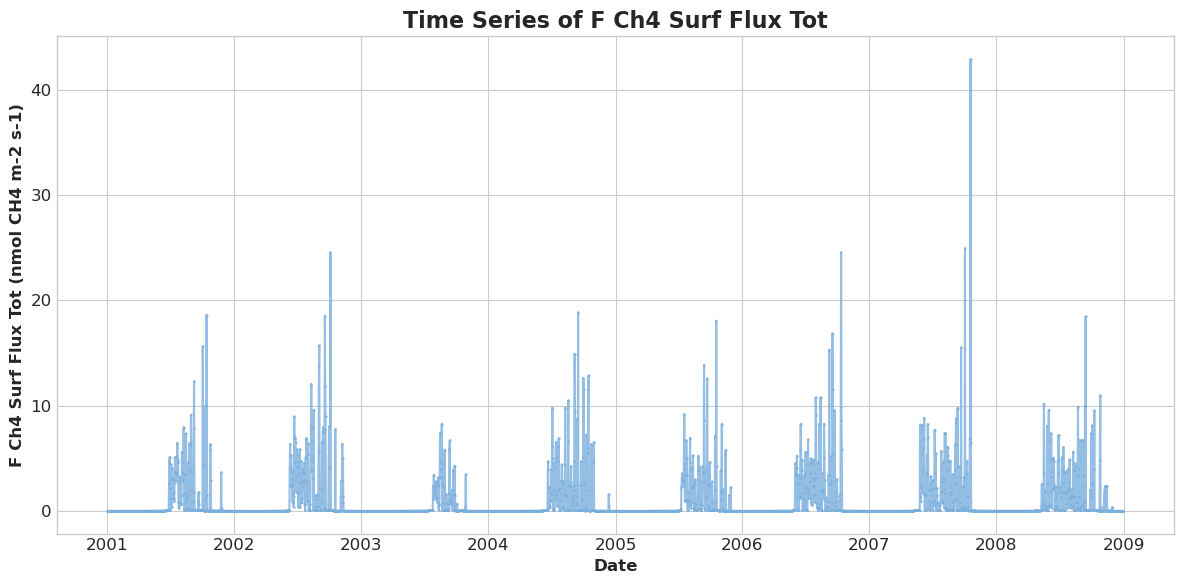

In [4]:
%matplotlib inline
import xarray as xr
import matplotlib.pyplot as plt
import os

# --- User Configuration ---
# 1. Set the path to your NetCDF file.
#    Example: 'C:/data/weather_data.nc' or '/user/home/data/model_output.nc'
path = '/share/home/dq076/data/cases/ME/ME_s_US-Los/history/'
nc_file_path = path + 'ME_s_US-Los_hist_2001-2008.nc'  # <-- CHANGE THIS

# 2. Set the name of the variable you want to plot from the file.
#    Example: 'temperature', 'precipitation', 'T2'
variable_name = 'f_ch4_surf_flux_tot'  # <-- CHANGE THIS

# 3. Set the desired output image file name.
output_image_path = f'{variable_name}_timeseries.png'
# --------------------------

def plot_time_series(data_array, output_path):
    """
    Generates and saves a time series plot from an xarray DataArray.

    Args:
        data_array (xr.DataArray): The data array with a 'time' coordinate to plot.
        output_path (str): The path to save the output image file.
    """
    # --- Plot Settings ---
    # You can adjust these values to change the plot's appearance
    plt.style.use('seaborn-v0_8-whitegrid') # Use a nice-looking plot style
    plt.rcParams['figure.figsize'] = (12, 6) # Set figure size (width, height in inches)
    plt.rcParams['font.size'] = 12          # Set base font size
    
    # Create the plot figure and axes
    fig, ax = plt.subplots()

    # --- Plotting ---
    # Use xarray's built-in plotting capabilities. It automatically uses the 'time' coordinate for the x-axis.
    data_array.plot.line(ax=ax, marker='^', markersize=1, linestyle='-',alpha=0.8, color='#7aaedc')

    # --- Titles and Labels ---
    # Automatically get metadata from the xarray object for smart labels
    long_name = data_array.attrs.get('long_name', variable_name.replace('_', ' ').title())
    units = data_array.attrs.get('units', '')
    
    # Set the plot title and axis labels
    ax.set_title(f'Time Series of {long_name}', fontsize=16, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12, fontweight='bold')
    # ax.set_ylabel(f'{long_name} ({units})' if units else long_name, fontsize=12, fontweight='bold')
    ax.set_ylabel(f'{long_name} (nmol CH4 m-2 s-1)', fontsize=12, fontweight='bold')
    
    # Improve layout to prevent labels from overlapping
    plt.tight_layout()

    # --- Save and Show Plot ---
    # try:
    #     plt.savefig(output_path, dpi=300) # Save the figure with high resolution
    #     print(f"✅ Plot saved successfully to: {output_path}")
    # except Exception as e:
    #     print(f"❌ Error saving plot: {e}")

    plt.show() # Display the plot


def main():
    """
    Main function to load data and generate the plot.
    """
    # 1. Validate that the file exists
    if not os.path.exists(nc_file_path):
        print(f"❌ Error: File not found at '{nc_file_path}'")
        print("--> Please update the 'nc_file_path' variable with the correct path.")
        return

    # 2. Open the NetCDF file using a 'with' statement for safety
    try:
        with xr.open_dataset(nc_file_path) as ds:
            # 3. Validate that the chosen variable exists in the file
            if variable_name not in ds.variables:
                print(f"❌ Error: Variable '{variable_name}' not found in the file.")
                print(f"--> Available variables are: {list(ds.variables.keys())}")
                return

            # 4. Select the data variable and use .squeeze() to remove any 
            #    dimensions of size 1 (e.g., a single latitude or longitude).
            data_to_plot = (ds[variable_name][:,0]/(16.043*10**-9)).squeeze()

            # 5. Check if 'time' is a coordinate in the selected data
            if 'time' not in data_to_plot.dims:
                print(f"❌ Error: The variable '{variable_name}' does not have a 'time' dimension.")
                print(f"--> Its dimensions are: {data_to_plot.dims}")
                return
            
            # 6. Call the plotting function
            print(f"Plotting variable '{variable_name}' from {os.path.basename(nc_file_path)}...")
            plot_time_series(data_to_plot, output_image_path)

    except Exception as e:
        print(f"❌ An unexpected error occurred: {e}")

# This ensures the main() function runs when the script is executed
if __name__ == "__main__":
    main()

发生了一个意外错误: float() argument must be a string or a real number, not 'cftime._cftime.DatetimeGregorian'


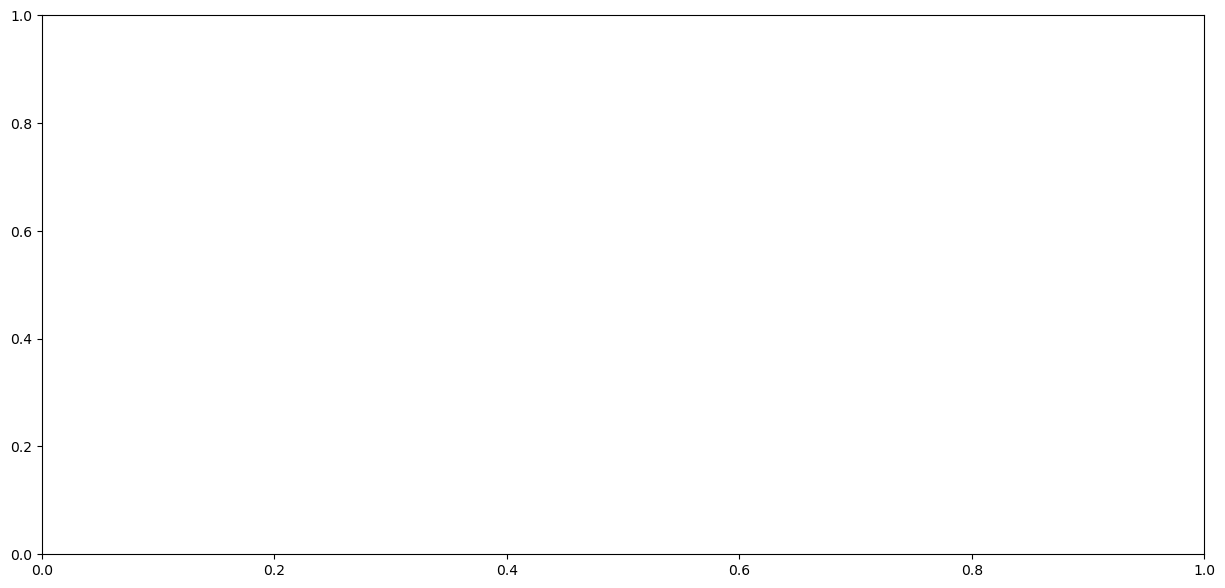

In [ ]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # 导入用于日期格式化的模块

# --- 1. 打开NetCDF文件 ---
# 将 'ME_s_US-Los_hist_2001-2008.nc' 替换为您的实际文件路径
dir_path = '/share/home/dq076/data/cases/ME/ME_s_US-Los/history/'
file_name = 'ME_s_US-Los_hist_2001-2008.nc'
file_path = dir_path + file_name

try:
    # 使用 'with' 语句确保文件在使用后能被正确关闭
    with nc.Dataset(file_path, 'r') as dataset:
        
        # --- 2. 读取变量 ---
        # 读取时间变量及其单位
        time_var_in = dataset.variables['time']
        time_vals = time_var_in[:]
        time_units = time_var_in.units
        
        # 读取CH4通量变量
        ch4_flux_2d = dataset.variables['f_ch4_surf_flux_tot'][:, :]
        
        # 获取变量的单位和长名称，用于图表标签
        ch4_units = dataset.variables['f_ch4_surf_flux_tot'].units
        ch4_long_name = dataset.variables['f_ch4_surf_flux_tot'].long_name

        # --- 3. 数据处理 ---
        # *** 新增：将数值时间转换为datetime对象 ***
        # 使用 netCDF4.num2date 将时间值从 "minutes since 1900-1-1" 转换为可读的日期
        try:
            # calendar='standard' 是常用的日历格式
            dates = nc.num2date(time_vals, units=time_units, calendar='standard')
        except ValueError:
            # 如果标准日历失败，尝试使用'gregorian'
            dates = nc.num2date(time_vals, units=time_units, calendar='gregorian')

        # 由于 f_ch4_surf_flux_tot 是二维的 (time, patch)，我们计算每个时间点上所有 patch 的平均值。
        # ch4_flux_1d = np.mean(ch4_flux_2d, axis=1)
        ch4_flux_1d = ch4_flux_2d

        # 找到通量数据中的最大值，用于设定Y轴范围
        max_flux_value = np.max(ch4_flux_1d)

        # --- 4. 绘制图表 ---
        # 创建一个图形和一个坐标轴
        fig, ax = plt.subplots(figsize=(15, 7)) # 稍微加宽图形以容纳日期标签

        # *** 修改：使用转换后的日期作为X轴数据 ***
        ax.plot(dates, ch4_flux_1d, label=ch4_long_name)

        # --- 5. 设置图表属性 ---
        # 设置图表标题
        ax.set_title('CH4 Surface Flux Time Series (2001-2008)', fontsize=16)
        
        # 设置X轴标签
        ax.set_xlabel('Date', fontsize=12)
        
        # 设置Y轴标签
        ax.set_ylabel(f'CH4 Flux ({ch4_units})', fontsize=12)
        
        # 设置Y轴的范围：最小值为0，最大值为数据的最大值
        ax.set_ylim(0, max_flux_value * 1.05) # 乘以1.05是为了让图表顶部留出一点空间
        
        # 添加网格线，使图表更易读
        ax.grid(True, linestyle='--', alpha=0.6)
        
        # 添加图例
        ax.legend()
        
        # *** 新增：格式化X轴日期显示 ***
        # 设置主刻度定位器：每6个月一个刻度
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
        # 设置主刻度格式化器：显示为 "年-月"
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        
        # 自动旋转X轴的日期标签，防止重叠
        fig.autofmt_xdate()
        
        # 自动调整布局
        plt.tight_layout()
        
        # 显示图表
        plt.show()

except FileNotFoundError:
    print(f"错误：文件 '{file_path}' 不存在。请检查文件路径是否正确。")
except KeyError as e:
    print(f"错误：文件中找不到变量 {e}。请确认变量名称是否正确。")
except Exception as e:
    print(f"发生了一个意外错误: {e}")